# classification : 分類問題

# Preparation

## Preparation of google drive (if required)

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch220118/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220118/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 6.9 MB/s 


In [ ]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

# Target Python Program

In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

## データ読み込み

In [7]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x  = torch.from_numpy(x_train).float()
y  = torch.from_numpy(y_train).long()
vx = torch.from_numpy(x_valid).float()
vy = torch.from_numpy(y_valid).long()

print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_valid : ', x_valid.shape)
print('y_valid : ', y_valid.shape)

x_train :  (112, 4)
y_train :  (112,)
x_valid :  (38, 4)
y_valid :  (38,)


## ニューラルネットワークの定義

In [8]:
class Model(torch.nn.Module):

  class Net( torch.nn.Module ):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.drop1 = nn.Dropout(0.5) ### drop
        self.fc2 = nn.Linear(64, 3)
    
    def forward(self, x):
        self.x1 = F.relu(self.fc1(x))
        #self.x2 = self.drop1(self.x1)  ## drop
        #x = self.fc2(self.x2)
        x = self.fc2(self.x1)
        return x

  class Loss( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create loss class")

    def forward(self,y,t):
      loss = nn.CrossEntropyLoss()
      #loss = nn.NLLLoss()
      output = loss( y, t )
      return output

  def __init__( self, t ):
    super( Model, self ).__init__()
    print("create model class")
    self.net  = self.Net()
    self.loss = self.Loss()
    self.target = t

  def forward( self, x ):
    self.out = self.net( x )
    out = self.loss( self.out, self.target )
    return out

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [9]:
project = 'clas'
folder = './classification'
json_path = folder + '/' + project +'.json'

In [10]:
! mkdir -p classification

## 計算グラフをJSONファイルに出力する

In [11]:
def generate_json( json_path, input, target ):
    model = Model( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )
    return model

In [12]:
torch.manual_seed( 1 )

batch_size = 16
print(x.shape)
print(y.shape)
inputs = x[0:batch_size,:]
labels = y[0:batch_size]
inputs.requires_grad = True

model = generate_json( json_path, inputs, labels )

torch.Size([112, 4])
torch.Size([112])
create model class
create loss class
[SAVE] ./classification/clas.json
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc2]/weight/fc2
skip: Model/Net[net]/Linear[fc2]/weight/fc2


一回の順伝播、逆伝播のC++コードを生成する

In [13]:
minictorch.convert_all( project, folder, model, json_path, inputs, {"input_data":x_train, "target_data":y_train}, sol="classification", batch=batch_size, shuffle=1 )

[JSON] ./classification/clas.json
param: xin  - str loop  7  /  7
{'name': 'Model/Net[net]/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
param: fc1_weight  - str loop  31  /  31
{'name': 'Model/Net[net]/Linear[fc1]/bias/bias.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
param: fc1_bias  - str loop  7  /  7
{'name': 'Model/Net[net]/Linear[fc2]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
param: fc2_weight  - str loop  23  /  23
{'name': 'Model/Net[net]/Linear[fc2]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
param: fc2_bias  - str loop  0  /  0
{'name': 'Model/Loss[loss]/60', 'op': 'prim::Constant', 'in': [], 'output_id': 0, 'shape': [16], 'constant_value': [1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0], 'out': [13], 

In [14]:
#check code
with torch.set_grad_enabled(True):
  output = model( inputs )
  print("output",output)

  model.zero_grad()
  output.backward()
  print("output grad",output.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  preds = torch.argmax( model.out, dim=1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

output tensor(1.2166, grad_fn=<NllLossBackward0>)
output grad None
input grad tensor([[ 6.8985e-03, -2.6538e-03,  8.4706e-03,  3.2216e-03],
        [-9.2211e-03, -3.1165e-03,  2.7813e-03, -3.2340e-03],
        [ 2.5795e-03,  2.9746e-03,  7.0751e-03, -6.9228e-04],
        [-1.2729e-02, -3.6763e-03,  2.0663e-03, -1.8041e-03],
        [ 2.5329e-03,  7.9646e-03, -4.2052e-04,  4.6976e-03],
        [ 5.8694e-03,  6.7901e-03, -7.2889e-03,  6.0781e-03],
        [ 9.9282e-03,  5.7972e-03, -5.3229e-03,  4.5169e-03],
        [ 3.3862e-03,  7.1265e-03, -1.1610e-03,  5.8808e-03],
        [-3.8514e-03, -1.0597e-03, -4.3194e-03, -8.3708e-03],
        [-8.6227e-03, -3.5877e-03,  2.7323e-03, -3.4626e-03],
        [-9.7263e-03, -4.2901e-03,  4.6547e-03, -4.3446e-03],
        [-7.4391e-03, -1.6775e-03, -1.1533e-03,  4.0695e-05],
        [-1.0267e-02, -4.4895e-03,  8.4923e-04, -1.1563e-03],
        [ 4.8874e-03,  1.5375e-03,  8.5821e-03, -4.4723e-03],
        [-8.6621e-03, -3.4958e-03,  2.8371e-03, -3.550

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


# C++予測コード

## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [ ]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git

In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

# コンパイル

In [16]:
C_SRC = './classification/clas.cpp ./classification/clas_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './classification/clas'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas.cpp ./classification/clas_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas


In [17]:
!./classification/clas

### forward computation ...
 1.216645
### backward computation ...
input_grad{{ 0.006899, -0.002654,  0.008471,  0.003222},
 {-0.009221, -0.003116,  0.002781, -0.003234},
 { 0.002579,  0.002975,  0.007075, -0.000692},
 {-0.012729, -0.003676,  0.002066, -0.001804},
 { 0.002533,  0.007965, -0.000421,  0.004698},
 { 0.005869,  0.00679 , -0.007289,  0.006078},
 { 0.009928,  0.005797, -0.005323,  0.004517},
 { 0.003386,  0.007126, -0.001161,  0.005881},
 {-0.003851, -0.00106 , -0.004319, -0.008371},
 {-0.008623, -0.003588,  0.002732, -0.003463},
 {-0.009726, -0.00429 ,  0.004655, -0.004345},
 {-0.007439, -0.001677, -0.001153,  0.000041},
 {-0.010267, -0.00449 ,  0.000849, -0.001156},
 { 0.004887,  0.001537,  0.008582, -0.004472},
 {-0.008662, -0.003496,  0.002837, -0.00355 },
 { 0.008285,  0.007717, -0.003415,  0.004024}}


# Python 学習コード

In [19]:
torch.manual_seed( 1 )

#inputs.requires_grad = True
model = Model( labels )

lr = 0.01
opt = torch.optim.SGD( model.parameters(), lr)

epochs = 200
batch_size = 16

num_train = len(x_train)
n_batch = num_train // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

epoch_loss = []
epoch_acc = []
for epoch in range(epochs):
    
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    model.train()   # モデルを訓練モードに設定

    total_loss = 0.0
    total_corrects = 0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        inputs = x[mb_index, :]
        labels = y[mb_index]
       
        # 順伝播と逆伝播
        model.target = labels
        loss = model( inputs )
        total_loss += loss;

        # 正解数の合計を更新
        #_, preds = torch.max( model.out, 1 )
        preds = torch.argmax( model.out, dim=1 )
        num = torch.sum( preds == labels )
        total_corrects += num

        opt.zero_grad()
        loss.backward()
        opt.step()

    total_acc  = total_corrects.double() / float(num_train)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, total_loss, total_acc, total_corrects ))

    epoch_loss.append( total_loss )
    epoch_acc.append( total_acc )

create model class
create loss class
batch 7 112 16
Train Loss 0: 7.6509 Acc: 0.1964 22
Train Loss 1: 6.6511 Acc: 0.4464 50
Train Loss 2: 5.9164 Acc: 0.6964 78
Train Loss 3: 5.3746 Acc: 0.7232 81
Train Loss 4: 4.9596 Acc: 0.7232 81
Train Loss 5: 4.6426 Acc: 0.7232 81
Train Loss 6: 4.3840 Acc: 0.7321 82
Train Loss 7: 4.1756 Acc: 0.7589 85
Train Loss 8: 3.9906 Acc: 0.7679 86
Train Loss 9: 3.8495 Acc: 0.7857 88
Train Loss 10: 3.7116 Acc: 0.7857 88
Train Loss 11: 3.5875 Acc: 0.7946 89
Train Loss 12: 3.4823 Acc: 0.8125 91
Train Loss 13: 3.3863 Acc: 0.8304 93
Train Loss 14: 3.3033 Acc: 0.8304 93
Train Loss 15: 3.2192 Acc: 0.8661 97
Train Loss 16: 3.1470 Acc: 0.8571 96
Train Loss 17: 3.0791 Acc: 0.8750 98
Train Loss 18: 3.0189 Acc: 0.8750 98
Train Loss 19: 2.9554 Acc: 0.8750 98
Train Loss 20: 2.9082 Acc: 0.8750 98
Train Loss 21: 2.8503 Acc: 0.8750 98
Train Loss 22: 2.8013 Acc: 0.8839 99
Train Loss 23: 2.7569 Acc: 0.8750 98
Train Loss 24: 2.7141 Acc: 0.8839 99
Train Loss 25: 2.6721 Acc: 0.8929

収束状況グラフを描画する

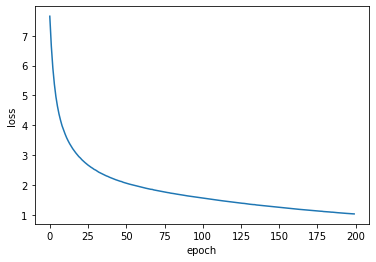

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

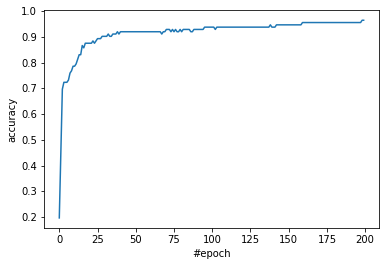

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_acc))),epoch_acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

# C++ 学習コード

学習用C++コードをコンパイル、リンクする

In [22]:
C_SRC = './classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './classification/clas_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas_train


In [23]:
! ./classification/clas_train

epoch_num : 200
batch  number  : 7,16
learning ratio : 0.01
total_loss (batch): epoch 0 : loss 7.64042 : Acc 0.142857 16
total_loss (all)  : epoch 0 : loss 1.0027 : Acc 0.267857 30
total_loss (batch): epoch 1 : loss 6.6572 : Acc 0.4375 49
total_loss (all)  : epoch 1 : loss 0.88458 : Acc 0.678571 76
total_loss (batch): epoch 2 : loss 5.93214 : Acc 0.6875 77
total_loss (all)  : epoch 2 : loss 0.796339 : Acc 0.705357 79
total_loss (batch): epoch 3 : loss 5.37368 : Acc 0.714286 80
total_loss (all)  : epoch 3 : loss 0.73065 : Acc 0.723214 81
total_loss (batch): epoch 4 : loss 4.97418 : Acc 0.723214 81
total_loss (all)  : epoch 4 : loss 0.679826 : Acc 0.723214 81
total_loss (batch): epoch 5 : loss 4.63794 : Acc 0.723214 81
total_loss (all)  : epoch 5 : loss 0.639691 : Acc 0.732143 82
total_loss (batch): epoch 6 : loss 4.38309 : Acc 0.732143 82
total_loss (all)  : epoch 6 : loss 0.607024 : Acc 0.741071 83
total_loss (batch): epoch 7 : loss 4.1728 : Acc 0.75 84
total_loss (all)  : epoch 7 : lo

In [24]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("[OUT]",path)
print("epoch =", len(loss))
print( loss )
print(acc)

[OUT] ./classification/clas.out
epoch = 200
[1.002704, 0.88458, 0.796339, 0.73065, 0.679826, 0.639691, 0.607024, 0.579808, 0.556694, 0.536558, 0.518862, 0.503061, 0.48879, 0.475887, 0.464116, 0.453277, 0.443265, 0.433972, 0.425335, 0.417256, 0.409689, 0.402594, 0.395919, 0.389625, 0.383675, 0.378034, 0.372685, 0.367604, 0.362764, 0.358155, 0.353762, 0.349557, 0.345527, 0.341663, 0.33797, 0.334408, 0.330992, 0.327712, 0.324541, 0.321484, 0.318531, 0.315677, 0.312923, 0.310254, 0.307668, 0.305158, 0.302723, 0.300355, 0.298057, 0.295822, 0.293649, 0.291534, 0.289466, 0.287456, 0.285491, 0.283571, 0.281696, 0.279861, 0.278066, 0.276304, 0.274581, 0.272887, 0.271223, 0.269591, 0.267989, 0.266415, 0.264867, 0.26335, 0.261853, 0.260382, 0.258932, 0.257502, 0.256094, 0.254708, 0.25334, 0.251989, 0.250655, 0.249337, 0.248039, 0.246759, 0.245495, 0.244244, 0.24301, 0.24179, 0.240585, 0.239392, 0.238214, 0.237048, 0.235889, 0.234745, 0.233608, 0.232479, 0.231361, 0.230256, 0.229162, 0.228078, 0.2

収束状況グラフを描画する

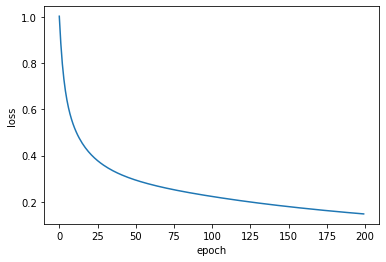

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

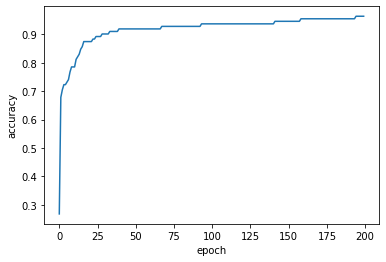

In [26]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()